In [1]:
import Pkg

In [2]:
using PyPlot,Random,CurveFit,GaussianProcesses

In [107]:
len_genome=1e7
len_read=100 # length of read
n_read=len_genome/len_read # no. of reads
n_read=Int64(n_read) # length of genome: 1e7
sim=rand(1:1e7,n_read);  # Using random the starting positions of reads of length 100 are simulated and stored in an array

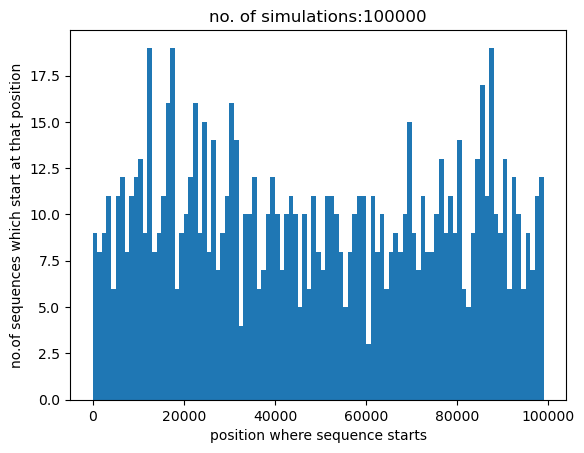

PyObject Text(0.5, 1.0, 'no. of simulations:100000')

In [109]:
hist(sim,bins=1:1000:1e5)
xlabel("position where sequence starts")
ylabel("no.of sequences which start at that position")
title("no. of simulations:"*string(n_read))

# Simulation of random reads onto the reference genome

## The algorithm: we simulate the starting position of a read and add 1.0 to next 100 positions as well. so the final array which we obtain we will have no. of coverages above a particular location. The array will look like  [1, 2, 3, 3, 3, 2, 2, 2, 2, 1, 1] , by visual inspection for coverage 1 we have 2 regions of length 1 and 2. For coverage 2 the lengths will be 1 and 4. For coverage 3 the lengths will be 3 alone. The below code just finds the length of these regions and plots are plotted.

In [101]:
function reads_on_genome()
    len_genome=Int32(1e7) # length of genome
    len_read=100 # length of a read
    n_reads=Int32(4*len_genome/len_read) # no. of reads
    genome=zeros(Int32,len_genome) # genome 
    for i in 1:n_reads
        j=rand(1:len_genome-100)
        genome[j]+=1
        genome[j+100] -= 1
    end
    # integrating the derivative array
    for pos in 2:len_genome
      genome[pos]=genome[pos]+genome[pos-1]
    end
    return genome
end

reads_on_genome (generic function with 1 method)

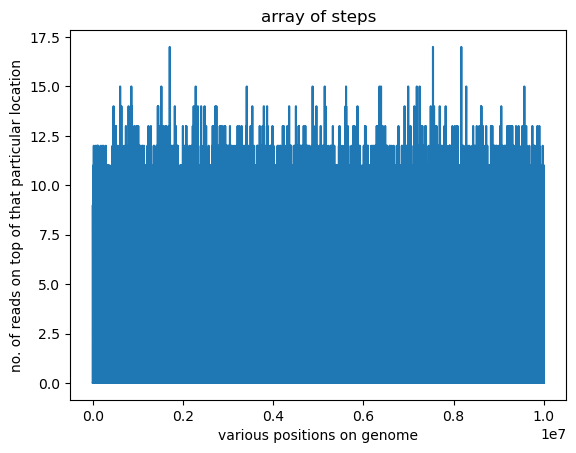

PyObject Text(24.00000000000002, 0.5, 'no. of reads on top of that particular location')

In [102]:
a=reads_on_genome()
plot(1:length(a),a)
title("array of steps")
xlabel("various positions on genome")
ylabel("no. of reads on top of that particular location")

# function to find lengths for various overlaps

In [7]:
function heights(a)
    length_dist = Dict{Int, Vector{Int}}()
    d=1
    h=a[1]
    for i in 2:len
      if a[i]==h
          d+=1
      else
          if d>0
              push!(get!(length_dist, h, Int[]), d)
          d=1
          h=a[i]
          end
      end
    end
  return length_dist
  end

heights (generic function with 1 method)

In [8]:
heights(a)

Dict{Int64, Vector{Int64}} with 14 entries:
  5  => [41, 23, 1, 40, 15, 16, 11, 4, 35, 2  …  3, 15, 6, 20, 27, 10, 1, 14, 7…
  12 => [15, 2, 16, 7, 2, 5, 2, 1, 17, 5, 5, 1]
  8  => [25, 1, 4, 7, 23, 40, 4, 14, 10, 7  …  34, 12, 22, 6, 5, 16, 15, 9, 15,…
  1  => [15, 49, 6, 22, 28, 59, 52, 27, 9, 60  …  15, 5, 11, 27, 5, 28, 1, 16, …
  0  => [59, 76, 28, 7, 25, 26, 36, 5, 15, 9  …  2, 36, 13, 5, 5, 6, 9, 4, 14, …
  6  => [5, 2, 1, 1, 3, 40, 10, 14, 24, 18  …  15, 2, 3, 5, 15, 15, 26, 4, 18, …
  11 => [3, 2, 4, 1, 11, 2, 1, 6, 6, 1  …  2, 2, 1, 3, 1, 13, 2, 6, 1, 3]
  9  => [14, 19, 7, 2, 4, 5, 8, 18, 8, 13  …  6, 5, 6, 4, 4, 2, 12, 7, 2, 1]
  3  => [7, 6, 9, 2, 10, 10, 8, 14, 22, 8  …  35, 16, 26, 37, 14, 37, 10, 33, 3…
  7  => [3, 1, 8, 2, 5, 8, 4, 5, 20, 19  …  5, 10, 15, 4, 21, 3, 13, 16, 6, 8]
  4  => [69, 9, 17, 4, 2, 27, 27, 44, 3, 2  …  15, 4, 11, 3, 11, 7, 21, 1, 15, …
  13 => [7, 6]
  2  => [9, 5, 2, 7, 16, 3, 10, 8, 5, 46  …  5, 27, 30, 3, 55, 3, 21, 15, 7, 18]
  10 => [1, 23,

In [9]:
h=heights(a);

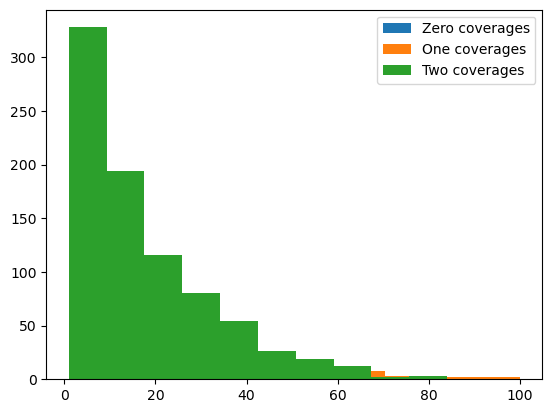

In [10]:
hist(h[0],label="Zero coverages")
hist(h[1],label="One coverages")
hist(h[2],label="Two coverages")
legend()
show()

# Fitting the simulated data to an exponential function

In [110]:
function plot_exp_fit(index,str)
    h=[]
    for i in 1:1000
        a1=reads_on_genome()
        h=vcat(h,heights(a1)[index])
    end
    h0=fill(0.0,maximum(h))
    for i in h
        h0[i]+=1
    end
    h0=h0./1000
    x0=Float64[i for i in 1:maximum(h)]
    x0=x0[1:100]
    h0=h0[1:100]
    fit0=curve_fit(ExpFit,x0,h0)
    y0=fit0.(x0)
    figure(figsize=(10,5))
    scatter(x0,log.(h0),label="Simulated data")
    scatter(x0,log.(y0),label="Exponential fit")
    title(str*" coverages")
end

plot_exp_fit (generic function with 1 method)

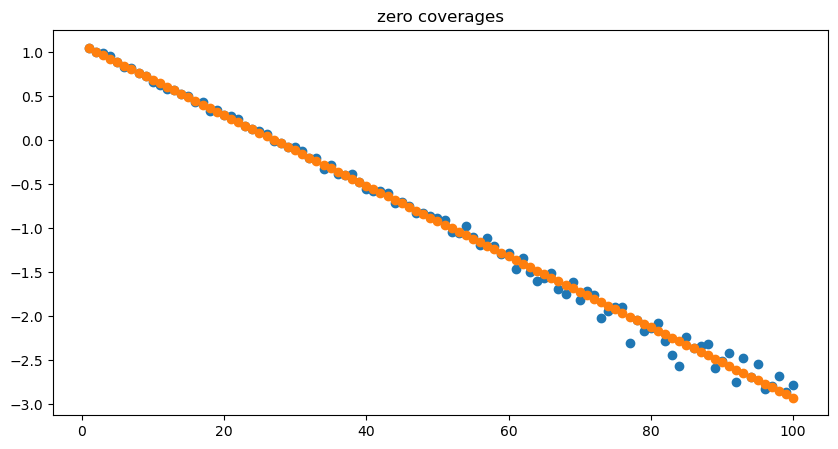

PyObject Text(0.5, 1.0, 'zero coverages')

In [111]:
plot_exp_fit(0,"zero")

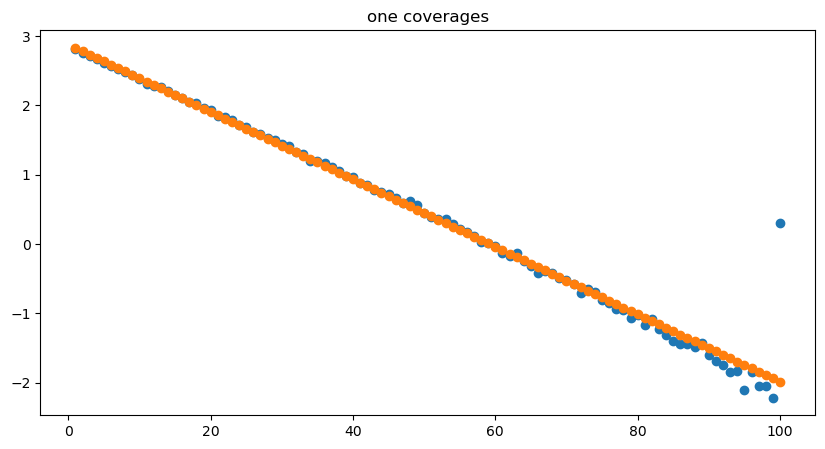

PyObject Text(0.5, 1.0, 'one coverages')

In [112]:
plot_exp_fit(1,"one")

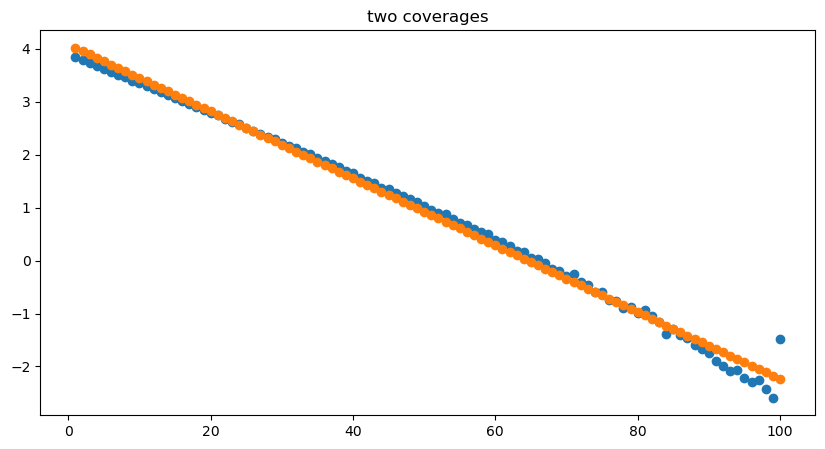

PyObject Text(0.5, 1.0, 'two coverages')

In [113]:
plot_exp_fit(2,"two")